<a href="https://colab.research.google.com/github/Crispy12138/Graduation_project/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np



# Parameters from Table 1
T10 = 300  # K
F10 = 5    # m^3/h
V1 = 1     # m^3
T1s = 402  # K
CA1s = 1.95  # kmol/m^3
CA10s = 4    # kmol/m^3
Q1s = 0.0  # kJ/hr
k0 = 8.46e6  # m^3/kmol h
Cp = 0.231  # kJ/kg K
rhoL = 1000 # kg/m^3
R = 8.314  # kJ/kmol K
E = 5e4    # kJ/kmol
DeltaH = -1.15e4  # kJ/kmol

T20 = 300  # K
F20 = 5    # m^3/h
V2 = 1     # m^3
T2s = 402  # K
CA2s = 1.95  # kmol/m^3
CA20s = 4    # kmol/m^3
Q2s = 0.0  # kJ/hr


delta_CA0_min , delta_CA0_max=  -3.5, 3.5
delta_Q_min ,delta_Q_max = -5e5, 5e5
delta_CA_min ,delta_CA_max = -1.95, 2
delta_T_min , delta_T_max = -100, 100

# defination of Lyapunov function V(x) = xTPx
P = np.mat([[1060,22],[22,0.52]])
rou = 380.0

# filter points of x within the ellipse
def x_calculator (initial_number,r):
    x_list = []
    conc = np.linspace(delta_CA_min, delta_CA_max, initial_number)
    temp = np.linspace(delta_T_min,  delta_T_max,  initial_number)
    for i in range(conc.size):
        for j in range(temp.size):
            x = np.array([[conc[i]],[temp[j]]])
            Vx = x.T @ P @ x
            if Vx <= r:
                x_list.append(x.flatten())
    final_x = np.array(x_list).T
    return final_x

# disrupt x points -> x points of CSTR 2
def x_transform(x1):
    x2 = x1.copy().T
    np.random.shuffle(x2)
    x2=x2.T
    return x2

# calculate the raw values of input
def XY_calculator(h,time_step,x01,x02,number_of_point):

    delta_CA10 =np.linspace(delta_CA0_min,delta_CA0_max, number_of_point)
    delta_CA20 =x_transform(delta_CA10)

    delta_Q1   =np.linspace(delta_Q_min , delta_Q_max,   number_of_point)
    delta_Q2   =x_transform(delta_Q1)
    t = np.arange(0,(time_step*h),h)

    X = np.zeros((number_of_point,time_step,8))
    Y = np.zeros((number_of_point,time_step,4))

    for i in range(number_of_point):

        CA1 = x01[0][i] + CA1s
        T1 = x01[1][i] + T1s
        CA2 = x02[0][i] + CA2s
        T2 = x02[1][i] + T2s

        CA10 = delta_CA10[i] + CA10s
        Q1 = delta_Q1[i] + Q1s
        CA20 = delta_CA20[i] + CA20s
        Q2 = delta_Q2[i] + Q2s

        for j in range(time_step):
            X[i,j] = [x01[0][i], x01[1][i], x02[0][i], x02[1][i], \
                      delta_CA10[i], delta_Q1[i],delta_CA20[i], delta_Q2[i]]
            Y[i,j] = [CA1-CA1s, T1-T1s , CA2-CA2s, T2-T2s]
            r1 = k0 * np.exp(-E / (R * T1)) * CA1**2
            r2 = k0 * np.exp(-E / (R * T2)) * CA2**2
            CA1+= h * ((F10 / V1) * (CA10 - CA1) - r1)
            T1 += h * ((F10 / V1) * (T10 - T1) + (-DeltaH * r1) / (rhoL * Cp) + Q1 / (rhoL * Cp * V1))
            CA2+= h * ((F20 / V2) * CA20 + (F10 / V2) * CA1 - (F10 + F20) / V2 * CA2 - r2)
            T2 += h * ((F20 / V2) * T20 + (F10 / V2) * T1 - (F10 + F20) / V2 * T2 + (-DeltaH * r2) / (rhoL * Cp) + Q2s / (rhoL * Cp * V2))

    return X,Y


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

x01 = x_calculator(200,rou)
x02 = x_transform(x01)

h = 1e-4
time_step=100

number_of_point = np.size(x01,1)
X,Y = XY_calculator(h,time_step,x01,x02,number_of_point)
print(f"shape of X:{np.shape(X)}")
print(f"shape of Y:{np.shape(Y)}")


scaler_X = preprocessing.StandardScaler().fit(X.reshape(-1, 8))
scaler_y = preprocessing.StandardScaler().fit(Y.reshape(-1, 4))

RNN_input = scaler_X.transform(X.reshape(-1, 8)).reshape(-1,time_step,8)
RNN_output = scaler_y.transform(Y.reshape(-1, 4)).reshape(-1,time_step,4)
print(f"shape of X:{np.shape(RNN_input)}")
print(f"shape of Y:{np.shape(RNN_output)}")

'''print("RNN_input shape is {}".format(RNN_input.shape))
print("RNN_output shape is {}".format(RNN_output.shape))'''
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# checking X_train
np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('X_val.npy',X_val)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)
np.save('y_val.npy',y_val)

np.save('X_mean.npy',scaler_X.mean_)
np.save('X_std.npy',np.sqrt(scaler_X.var_))
np.save('y_mean.npy',scaler_y.mean_)
np.save('y_std.npy',np.sqrt(scaler_y.var_))


shape of X:(7304, 100, 8)
shape of Y:(7304, 100, 4)
shape of X:(7304, 100, 8)
shape of Y:(7304, 100, 4)


In [ ]:

import tensorflow as tf
import numpy as np
from keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis]
    return tf.cast(pos_encoding, dtype=tf.float32)
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])



In [ ]:
# 标记0值（填充值）
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # 添加额外的维度来将填充加到
  # 注意力对数（logits）。
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # q * k

  # 缩放 matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # 将 mask 加入到缩放的张量上。
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)
  # 将需要屏蔽的位置的数值变得非常负，使得经过softmaax计算后这些位置的注意力权重接近于0，从而达到屏蔽效果。

  # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
  # 相加等于1。
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
    # 将注意力头传递给一个dense层（全连接层）进行维度变换
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
    print(f"attention_weights{attention_weights}")

    return output, attention_weights

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dim_feedforward, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dim_feedforward)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training,mask):#query=x, value=x, key=x, attention_mask=look_ahead_mask
        attn_output = self.attention(query=inputs, value=inputs, key=inputs,attention_mask=None)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = out1 + ffn_output
        return self.layernorm2(ffn_output)



In [ ]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self,num_layers,d_model,num_heads,dff,
                 positions, rate=0.1):
        # 删去了input_vocabulary_size，因为输入序列长度全部是相等的
        # maximum_position_encoding是position encoding 的position,代表encoding的最大长度
        # (其实就是10）
        # 其实seq_len和maximum_position_encoding是一样的，但是init的时候还没有
        super(Encoder,self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(units=self.d_model,activation='linear')
        print(f"positions_of_encoder={positions}")
        self.pos_encoding = positional_encoding(positions,self.d_model)

        self.enc_layers = [EncoderLayer(d_model,num_heads,dff) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        print(f"x={x.shape},pe={self.pos_encoding[:, :seq_len, :].shape}")
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training,mask)
        return x


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    print(x.shape)
    print(enc_output.shape)
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    # def __init__(self, num_layers, d_model, num_heads, dff,
    # target_size不需要, maximum_position_encoding, rate=0.1):

    # maximum_position_encoding是时间步数=10
    def __init__(self,num_layers, d_model, num_heads, dff,
                 maximum_position_encoding, rate=0.1):
        super(Decoder,self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # 将时间序列中的8个features 扩展为d_model的向量
        # decoder也需要，因为decoder要对 Y_train进行理解。
        self.embedding = tf.keras.layers.Dense(units=self.d_model,activation='linear')
        self.pos_encoding = positional_encoding(maximum_position_encoding,self.d_model)
        self.dec_layers = [DecoderLayer(d_model,num_heads,dff,rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask,padding_mask):

        attention_weights = {}
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        x += self.pos_encoding[:,:seq_len,:]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):#(self, x, enc_output, training, look_ahead_mask):
            x,block1,block2 = self.dec_layers[i](x,enc_output,training,look_ahead_mask,padding_mask)
            # x= self.dec_layers[i](x,enc_output,training,look_ahead_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        return x ,attention_weights



In [ ]:
def create_masks(inp, tar):

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  return look_ahead_mask

In [ ]:
#def __init__(self, num_layers, d_model, num_heads,
                 # dff, position_size, target_size, rate=0.1):
def build_transformer_model(d_model, num_heads, dff, training,output_shape = 4, positions=100,num_layers=1,rate=0.1):

    encoder_input_shape = (positions, 8)  # Adjust based on your actual input shape
    decoder_input_shape = (positions, 4)  # Adjust based on your actual input shape

    encoder_inputs = Input(shape=encoder_input_shape)
    decoder_inputs = Input(shape=decoder_input_shape)

    enc_padding_mask=None
    look_ahead_mask = create_masks(encoder_inputs, decoder_inputs)
    #print(f"look_ahead_mask={look_ahead_mask.shape}")
    dec_padding_mask = None

    Encoder_ = Encoder(num_layers,d_model,num_heads,dff,positions)
    encoder_output = Encoder_(encoder_inputs,training=training, mask= enc_padding_mask)

    Decoder_ = Decoder(num_layers,d_model,num_heads,dff,positions)
    #def call(self, x, enc_output, training, look_ahead_mask):
    decoder_output ,attention_weights= Decoder_(decoder_inputs,encoder_output,
                        training=training,look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)
    final_layer_= tf.keras.layers.Dense(output_shape)
    final_output = final_layer_(decoder_output)

    return Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_output)



positions_of_encoder=100
x=(None, 100, 64),pe=(1, 100, 64)
(None, 100, 64)
(None, 100, 64)
attention_weightsTensor("decoder/decoder_layer/multi_head_attention_1/Softmax:0", shape=(None, 8, 100, 100), dtype=float32)
attention_weightsTensor("decoder/decoder_layer/multi_head_attention_2/Softmax:0", shape=(None, 8, None, None), dtype=float32)
Epoch 1/500
x=(None, 100, 64),pe=(1, 100, 64)
(None, 100, 64)
(None, 100, 64)
attention_weightsTensor("model/decoder/decoder_layer/multi_head_attention_1/Softmax:0", shape=(None, 8, 100, 100), dtype=float32)
attention_weightsTensor("model/decoder/decoder_layer/multi_head_attention_2/Softmax:0", shape=(None, 8, None, None), dtype=float32)
x=(None, 100, 64),pe=(1, 100, 64)
(None, 100, 64)
(None, 100, 64)
attention_weightsTensor("model/decoder/decoder_layer/multi_head_attention_1/Softmax:0", shape=(None, 8, 100, 100), dtype=float32)
attention_weightsTensor("model/decoder/decoder_layer/multi_head_attention_2/Softmax:0", shape=(None, 8, None, None), dtype=

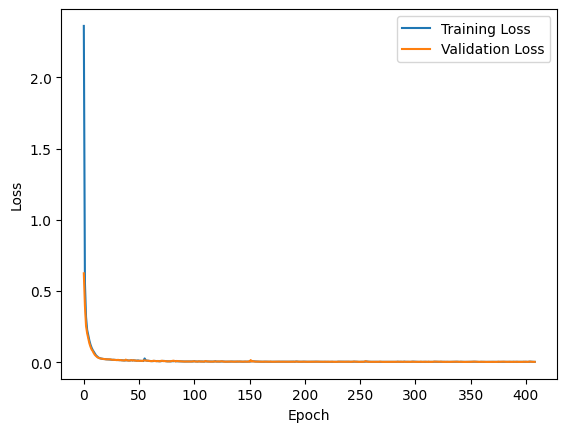

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense
import time

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_val = np.load('y_val.npy')

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

input_data_train=[X_train,y_train]
input_data_val=[X_val,y_val]

model = build_transformer_model(
    d_model=64,
    num_heads=8,
    dff=512,
    training=True
)

model.compile(optimizer=adam, loss=MeanSquaredError())

early_stopping = EarlyStopping(monitor='loss', patience=50, min_delta=1e-6, restore_best_weights=True)
start_time = time.time()
history = model.fit(
    [X_train,y_train], y_train,
    epochs=500,
    batch_size=500,
    validation_data=([X_val,y_val],y_val),
    callbacks=[early_stopping]
)
end_time = time.time()
total_training_time = end_time - start_time
print(f"total training time ={total_training_time}")

print(model.evaluate([X_test,y_test],y_test))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save('my_model_saved0.h5')

In [ ]:
import numpy as np
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

y_predict0 = model.predict([X_test,y_test])
y_predict_2d0 = y_predict0.reshape(-1, y_predict0.shape[-1])
y_predict_inversed = scaler_y.inverse_transform(y_predict_2d0)
y_predict0 = y_predict_inversed.reshape(y_predict0.shape)

x=(None, 100, 64),pe=(1, 100, 64)
(None, 100, 64)
(None, 100, 64)
attention_weightsTensor("model/decoder/decoder_layer/multi_head_attention_1/Softmax:0", shape=(None, 8, 100, 100), dtype=float32)
attention_weightsTensor("model/decoder/decoder_layer/multi_head_attention_2/Softmax:0", shape=(None, 8, None, None), dtype=float32)
69/69 [==============================] - 2s 12ms/step


Epoch 1/500
8/8 [==============================] - 5s 244ms/step - loss: 1.0603 - val_loss: 0.3623
Epoch 2/500
8/8 [==============================] - 2s 209ms/step - loss: 0.2612 - val_loss: 0.1507
Epoch 3/500
8/8 [==============================] - 2s 206ms/step - loss: 0.1255 - val_loss: 0.0796
Epoch 4/500
8/8 [==============================] - 2s 206ms/step - loss: 0.0783 - val_loss: 0.0574
Epoch 5/500
8/8 [==============================] - 2s 206ms/step - loss: 0.0568 - val_loss: 0.0394
Epoch 6/500
8/8 [==============================] - 2s 206ms/step - loss: 0.0428 - val_loss: 0.0302
Epoch 7/500
8/8 [==============================] - 2s 207ms/step - loss: 0.0343 - val_loss: 0.0239
Epoch 8/500
8/8 [==============================] - 2s 207ms/step - loss: 0.0283 - val_loss: 0.0190
Epoch 9/500
8/8 [==============================] - 2s 211ms/step - loss: 0.0235 - val_loss: 0.0157
Epoch 10/500
8/8 [==============================] - 2s 223ms/step - loss: 0.0200 - val_loss: 0.0131
Epoch 11/

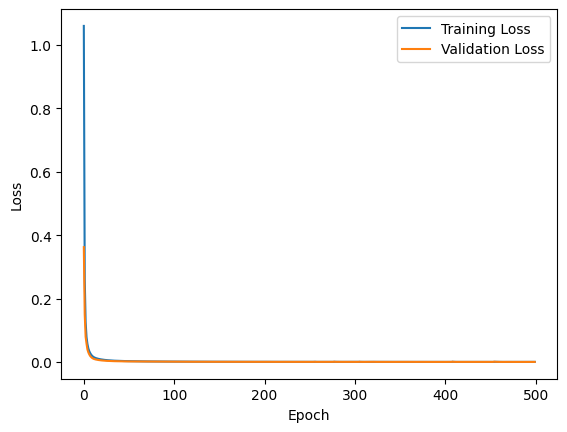

69/69 [==============================] - 1s 10ms/step - loss: 1.2636e-04
0.0001263633748749271


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dim_feedforward, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(dim_feedforward, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = out1 + ffn_output
        return self.layernorm2(ffn_output)


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis]
    return tf.cast(pos_encoding, dtype=tf.float32)

def build_transformer_model(input_shape, output_shape, d_model, num_heads, dim_feedforward):
    original_inputs = Input(shape=input_shape)
    position, _ = input_shape
    projection_layer = tf.keras.layers.Dense(units=d_model, activation='linear')
    projected_inputs = projection_layer(original_inputs)
    inputs_with_pe = positional_encoding(position, d_model) + projected_inputs
    transformer_layer = EncoderLayer(d_model, num_heads, dim_feedforward)
    x = transformer_layer(inputs_with_pe)
   # print(f"y in transformer_layer={y}")
    x = Dense(output_shape)(x)
    model = Model(original_inputs, x)
    return model

model = build_transformer_model(
    input_shape=(time_step, 8),
    output_shape=(4),
    d_model=64,
    num_heads=8,
    dim_feedforward=512
)

initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-6, restore_best_weights=True)
model.compile(adam,loss=MeanSquaredError())

start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=500,
    validation_split=0.1,
    callbacks=early_stopping
)
end_time = time.time()
total_training_time = end_time - start_time
print(f"total training time ={total_training_time}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(model.evaluate(X_test,y_test))
model.save('my_model_saved1.h5')

In [ ]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

y_predict1 = model.predict(X_test)
y_predict_2d1 = y_predict1.reshape(-1, y_predict1.shape[-1])
y_predict_inversed = scaler_y.inverse_transform(y_predict_2d1)
y_predict1 = y_predict_inversed.reshape(y_predict1.shape)

69/69 [==============================] - 1s 9ms/step


Epoch 1/500
8/8 [==============================] - 5s 286ms/step - loss: 0.8724 - val_loss: 0.7134
Epoch 2/500
8/8 [==============================] - 2s 234ms/step - loss: 3.8952 - val_loss: 0.5705
Epoch 3/500
8/8 [==============================] - 2s 283ms/step - loss: 0.5707 - val_loss: 0.5579
Epoch 4/500
8/8 [==============================] - 3s 369ms/step - loss: 0.5417 - val_loss: 0.5105
Epoch 5/500
8/8 [==============================] - 2s 233ms/step - loss: 0.4886 - val_loss: 0.4420
Epoch 6/500
8/8 [==============================] - 2s 232ms/step - loss: 0.4110 - val_loss: 1.2012
Epoch 7/500
8/8 [==============================] - 2s 236ms/step - loss: 0.7756 - val_loss: 0.3662
Epoch 8/500
8/8 [==============================] - 2s 239ms/step - loss: 0.3626 - val_loss: 0.3551
Epoch 9/500
8/8 [==============================] - 2s 255ms/step - loss: 0.3477 - val_loss: 0.3376
Epoch 10/500
8/8 [==============================] - 3s 399ms/step - loss: 0.3280 - val_loss: 0.3189
Epoch 11/

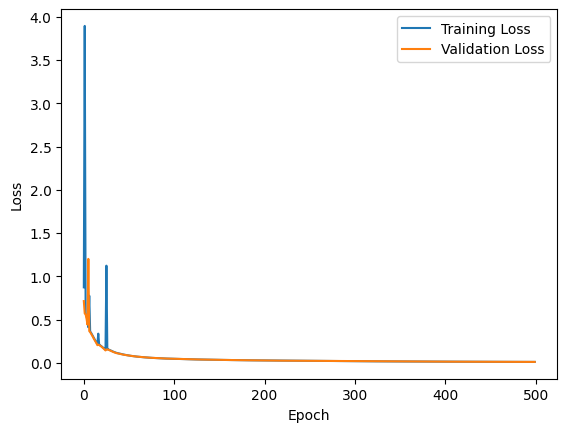

69/69 [==============================] - 2s 32ms/step - loss: 0.0099
0.009879415854811668


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import LSTM, Dense
import time
time_step = 100
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(96, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dense(4))
    model.compile(optimizer='adam',loss='mean_squared_error')
    return model

model = build_lstm_model((time_step, 8))

initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-6, restore_best_weights=True)
model.compile(adam,loss=MeanSquaredError())


start_time = time.time()
history = model.fit(X_train,y_train, epochs=500, batch_size=500, validation_split=0.1,callbacks=early_stopping)
end_time = time.time()
total_training_time = end_time - start_time
print(f"total training time ={total_training_time}")


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(model.evaluate(X_test,y_test))
model.save('my_model_saved2.h5')

69/69 [==============================] - 2s 32ms/step


<ipython-input-20-b577b4ae29a7>:27: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


(2192, 100, 4)
(2192, 100, 4)
(2192, 100, 4)
(2192, 100, 4)


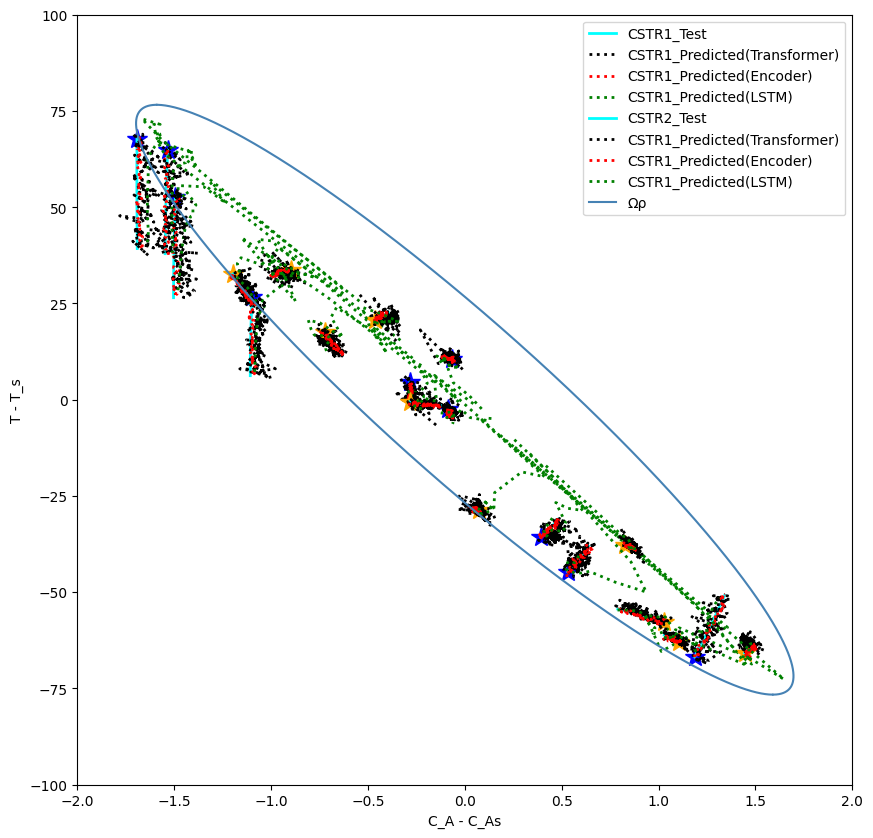

In [ ]:

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

y_predict2 = model.predict(X_test)
y_predict_2d2 = y_predict2.reshape(-1, y_predict2.shape[-1])
y_predict_inversed = scaler_y.inverse_transform(y_predict_2d2)
y_predict2 = y_predict_inversed.reshape(y_predict2.shape)


y_test_2d = y_test.reshape(-1, y_test.shape[-1])
y_test_inversed = scaler_y.inverse_transform(y_test_2d)
y_test = y_test_inversed.reshape(y_test.shape)

X_test_2d = X_test.reshape(-1, X_test.shape[-1])
X_plot_2d = scaler_X.inverse_transform(X_test_2d)
X_plot = X_plot_2d.reshape(X_test.shape)

y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

print(y_test.shape)
print(y_predict0.shape)
print(y_predict1.shape)
print(y_predict2.shape)

plt.figure(figsize=(10,10))

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15, color='blue')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='CSTR1_Test')
        plt.plot(y_predict0[i, :, 0], y_predict0[i, :, 1], color='black', lw=2, ls=':', label='CSTR1_Predicted(Transformer)')
        plt.plot(y_predict1[i, :, 0], y_predict1[i, :, 1], color='red', lw=2, ls=':', label='CSTR1_Predicted(Encoder)')
        plt.plot(y_predict2[i, :, 0], y_predict2[i, :, 1], color='green', lw=2, ls=':', label='CSTR1_Predicted(LSTM)')

        plt.plot(X_plot[i, 0, 2], X_plot[i, 0, 3], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 2], y_test[i, :, 3], color='cyan', lw=2, label='CSTR2_Test')
        plt.plot(y_predict0[i, :, 2], y_predict0[i, :, 3], color='black', lw=2, ls=':', label='CSTR1_Predicted(Transformer)')
        plt.plot(y_predict1[i, :, 2], y_predict1[i, :, 3], color='red', lw=2, ls=':', label='CSTR1_Predicted(Encoder)')
        plt.plot(y_predict2[i, :, 2], y_predict2[i, :, 3], color='green', lw=2, ls=':', label='CSTR1_Predicted(LSTM)')

    else:
        plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15, color='blue')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
        plt.plot(y_predict0[i, :, 0], y_predict0[i, :, 1], color='black', lw=2, ls=':')
        plt.plot(y_predict1[i, :, 0], y_predict1[i, :, 1], color='red', lw=2, ls=':')
        plt.plot(y_predict2[i, :, 0], y_predict2[i, :, 1], color='green', lw=2, ls=':')
        plt.plot(X_plot[i, 0, 2], X_plot[i, 0, 3], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 2], y_test[i, :, 3], color='cyan', lw=2)
        plt.plot(y_predict0[i, :, 2], y_predict0[i, :, 3], color='black', lw=2, ls=':')
        plt.plot(y_predict1[i, :, 2], y_predict1[i, :, 3], color='red', lw=2, ls=':')
        plt.plot(y_predict2[i, :, 2], y_predict2[i, :, 3], color='green', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue',label='Ωρ')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()
